In [114]:
import numpy as np
import math
import matplotlib
import matplotlib.pyplot as plt
import cv2
import os
from PIL import Image

In [2]:
def initialize_parameters_he(layer_dims):
    parameters = {}
    num_layers = len(layer_dims)

    for l in range(1, num_layers):
        parameters['W' + str(l)] = np.random.randn(layer_dims[l],layer_dims[l-1])*np.sqrt(1/layer_dims[l - 1])
        parameters['b' + str(l)] = np.zeros((layer_dims[l],1)) * np.sqrt(1. /layer_dims[l - 1])
    
    return parameters

In [3]:
def initialize_velocity_momentum(parameters):
    v = {}
    
    num_layers = len(parameters) // 2  

    for i in range(1, num_layers + 1):
        v["dw" + str(i)] = np.zeros((parameters["W" + str(i)].shape[0], parameters["W" + str(i)].shape[1]))
        v["db" + str(i)] = np.zeros((parameters["b" + str(i)].shape[0], parameters["b" + str(i)].shape[1]))
        

    return v

In [4]:
def linear_forward(a, w, b):
    z = np.dot(w,a) + b
    cache = (a, w, b)

    return z, cache

In [5]:
def sigmoid(z):
    a = 1/(1 + np.exp(-1*z))
    activation_cache = {"Z": z}

    return a, activation_cache

In [6]:
def linear_activation_forward(a_prev, w, b):

    z, linear_cache = linear_forward(a_prev, w, b)
    a, activation_cache = sigmoid(z)

    cache = (linear_cache, activation_cache)

    return a, cache

In [7]:
def L_model_forward(x, parameters):
    cache_main = []
    a = x
    num_layers = len(parameters) // 2

    for l in range(1,num_layers+1):
        a_prev = a
        a, cache_temp = linear_activation_forward(a_prev, parameters["W" + str(l)],parameters["b" + str(l)])
        cache_main.append(cache_temp)

    return a, cache_main

In [8]:
def compute_cost_with_L2(al, y, parameters, lambd):

    m = y.shape[1]  
    parameters_sum = []
    num_layers = len(parameters) // 2

    cross_entropy_cost = (-1/m)*( np.sum( y*np.log(al) ) + np.sum( (1 - y)*np.log(1 - al) ) )

    return cross_entropy_cost


def compute_cost(al, y, parameters, lambd):
    cost = compute_cost_with_L2(al, y, parameters, lambd)
    return cost

In [9]:
def sigmoid_backward(da, activation_cache):
    # Since dz = da * g'(z)
    z = activation_cache["Z"]
    a = 1/(1 + np.exp(-1 * z))
    
    dz = np.multiply(da, a*(1 - a))
    return dz

In [10]:
def linear_backward(dz, cache, lambd):

    a_prev, w, b = cache
    m = a_prev.shape[1]

    dw = (1/m)*(np.dot(dz,a_prev.T)) + (lambd/m)*w
    db = (1/m)*(np.sum(dz, axis = 1, keepdims = True))
    da_prev = np.dot(w.T,dz)

    return da_prev, dw, db

In [11]:
def linear_activation_backward(da, cache, lambd):

    linear_cache, activation_cache = cache

    dz = sigmoid_backward(da, activation_cache)
    da_prev, dw, db = linear_backward(dz, linear_cache, lambd)
        
    return da_prev, dw, db

In [12]:
def L_model_backward(al, y, caches, lambd):
    grads = {}
    num_layers = len(caches)

    m = al.shape[1]
    y = y.reshape(al.shape)

    dal = - (np.divide(y, al) - np.divide(1 - y, 1 - al))

    current_cache = caches[num_layers - 1]
    linear_cache, activation_cache = current_cache

    grads["dA" + str(num_layers)], grads["dW" + str(num_layers)], grads["db" + str(num_layers)] =linear_activation_backward(dal, current_cache, lambd)

    for l in reversed(range(num_layers - 1)):
        current_cache = caches[l]

        da_prev_temp, dw_temp, db_temp = linear_activation_backward(grads["dA" + str(l + 2)], current_cache,lambd)

        grads["dA" + str(l + 1)] = da_prev_temp
        grads["dW" + str(l + 1)] = dw_temp
        grads["db" + str(l + 1)] = db_temp

    return grads

In [13]:
def update_parameters_with_momentum(parameters, grads, learning_rate, v, beta):
    num_layers = len(parameters) // 2

    for l in range(1, num_layers + 1):
        v["dw" + str(l)] = beta*v["dw" + str(l)] + (1 - beta)*grads["dW" + str(l)]
        v["db" + str(l)] = beta*v["db" + str(l)] + (1 - beta)*grads["db" + str(l)]
        parameters["W" + str(l)] -= (learning_rate * v["dw" + str(l)])
        parameters["b" + str(l)] -= (learning_rate * v["db" + str(l)])

    return parameters, v

In [14]:
def random_mini_batches(x, y, mini_batch_size = 128, seed = 0):
    np.random.seed(seed)

    m = x.shape[1]  
    mini_batches = []
    permutation = list(np.random.permutation(m))
    shuffled_x = x[ :, permutation]
    shuffled_y = y[ :, permutation]

    batches =  -(-m // mini_batch_size)
    for j in range(batches):

        begin = j * mini_batch_size
        end = min(begin + mini_batch_size, X_train.shape[1] - 1)
        mini_batch_x = shuffled_x[:, begin:end]
        mini_batch_y = shuffled_y[:, begin:end]
        mini_batch = (mini_batch_x, mini_batch_y)
        mini_batches.append(mini_batch)

    return mini_batches

In [45]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import seaborn as sns

def predict_train_accuracy(train_x, train_y, parameters):
    al = L_model_forward(train_x, parameters)[0]
    
    predictions = np.argmax(al, axis=0)
    labels = np.argmax(train_y, axis=0)

    #print(classification_report(predictions, labels))
    print(accuracy_score(labels,predictions))

def show_confuse_matrix(train_x, train_y, parameters):
    al = L_model_forward(train_x, parameters)[0]
    
    predictions = np.argmax(al, axis=0)
    labels = np.argmax(train_y, axis=0)

    cf_matrix = confusion_matrix(predictions, labels)
    plt.figure(figsize=(16, 6))
    sns.heatmap(cf_matrix, annot=True,cmap="OrRd",fmt='g')
    plt.title('Confusion Matrix', fontsize = 20) # title with fontsize 20
    plt.xlabel('Predicted Label', fontsize = 15) # x-axis label with fontsize 15
    plt.ylabel('True Label', fontsize = 15) # y-axis label with fontsize 15

In [16]:
def L_layer_model(x, y, layer_dims, learning_rate, epochs, print_cost, batch_size):
    costs = []
    seed = 10
    lambd = 0.3  # regularization parameter

    parameters = initialize_parameters_he(layer_dims)
    v = initialize_velocity_momentum(parameters)

    for i in range(1, epochs+1):
        seed += 1
        minibatches = random_mini_batches(x, y, batch_size, seed)
        for minibatch in minibatches:
            minibatch_x, minibatch_y = minibatch

            # A single forward pass
            al, caches = L_model_forward(minibatch_x, parameters)

            # Cost computing
            cost = compute_cost(al, minibatch_y, parameters, lambd)

            # Backward Pass
            grads = L_model_backward(al, minibatch_y, caches, lambd)

            # Update parameters
            parameters, v = update_parameters_with_momentum(parameters, grads, learning_rate, v, 0.9)

        if print_cost and i % 10 is 0:
            #print("Cost after epoch %i: %f" % (i, cost))
            predict_train_accuracy(x, y, parameters)
    

    return parameters

In [17]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1)
X,y=mnist["data"],mnist["target"]

# scale
X = X / 255

# one-hot encode labels
digits = 10
examples = y.shape[0]
y = y.reshape(1, examples)
Y_new = np.eye(digits)[y.astype('int32')]
Y_new = Y_new.T.reshape(digits, examples)

# split, reshape, shuffle
m = 60000
m_test = X.shape[0] - m
X_train, X_test = X[:m].T, X[m:].T
Y_train, Y_test = Y_new[:,:m], Y_new[:,m:]
shuffle_index = np.random.permutation(m)
X_train, Y_train = X_train[:, shuffle_index], Y_train[:, shuffle_index]

In [18]:
print(np.shape(X_train))
print(np.shape(Y_train))

(784, 60000)
(10, 60000)


In [19]:
layer_dims = [784, 200,100,50, 10]

parameters = L_layer_model(X_train, Y_train, layer_dims, 0.5, 100, True, 256)

0.9182333333333333
0.94115
0.9538666666666666
0.9584666666666667
0.9568166666666666
0.9609
0.9633666666666667
0.9617166666666667
0.9648333333333333
0.9650333333333333
[[5825    1   45   10    7   22   33   12   20   38]
 [   0 6647   43   17   40   12   17   46   57   18]
 [   2   18 5654   31   14    3    2   45   10    1]
 [   6   14   37 5861    0   38    0    7   53   51]
 [   3    4   36    0 5646   13   28   42   10   68]
 [  15    7    1   73    4 5227   42    8   25   28]
 [  20    4   26    9   33   57 5761    0   36    1]
 [   2   15   48   35    6    2    0 6039    1   56]
 [  44   26   62   59   10   24   35    3 5603   49]
 [   6    6    6   36   82   23    0   63   36 5639]]


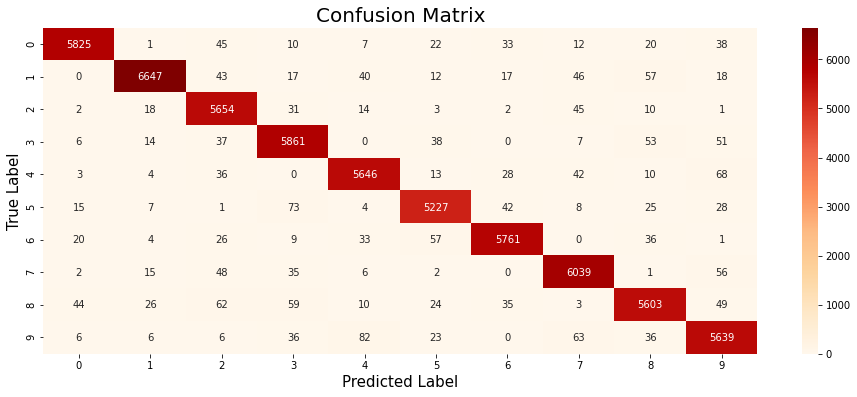

In [46]:
show_confuse_matrix(X_train, Y_train, parameters)

In [20]:
predict_train_accuracy(X_test, Y_test, parameters)

0.9621


In [48]:
X_test[:,5].shape

(784,)

In [50]:
X_test[:,5].reshape(784, 1).shape

(784, 1)

In [52]:
print(len(L_model_forward(X_test[:,5].reshape(784, 1), parameters)[0]))
L_model_forward(X_test[:,5].reshape(784, 1), parameters)[0]

10


array([[1.93897421e-07],
       [9.87825933e-01],
       [3.90458661e-03],
       [2.26245235e-03],
       [1.03468752e-02],
       [6.80400322e-03],
       [4.79041523e-04],
       [2.71810396e-02],
       [2.75854032e-03],
       [3.16535795e-04]])

In [56]:
print(np.argmax(L_model_forward(X_test[:,5].reshape(784, 1), parameters)[0]))
print(np.argmax(Y_test[:,5],axis=0))

1
1


In [104]:
def predict_number(x,parameters):
    return np.argmax(L_model_forward(x.reshape(784, 1), parameters)[0])
def check_predict(x, y, i,parameters):
    print(predict_number(x[:,i], parameters))
    print(np.argmax(y[:,i],axis=0))

9
9


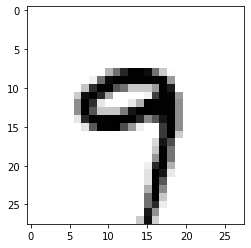

In [154]:
i=np.random.randint(0,10000,1).item()
check_predict(X_test, Y_test, i,parameters)
plt.imshow(X_test[:,i].reshape(28,28), cmap = matplotlib.cm.binary)

In [68]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [87]:
ls

'3423 HW 4.pdf'
'3423 Test 2.pdf'
 AI_COLAB/
 Anh_Nguyen_900470135.py
'AnhNguyen_Agreement (1).pdf'
 AnhNguyen_Agreement.pdf
 Anh_Nguyen_ComputerVision_2021.docx
 AnhNguyen_HW_83120.pdf
 AnhNguyen_Hw8.ipynb
 AnhNguyen_otherforms.pdf
 AnhNguyen_SA_contract.pdf
'Anh Tuan Nguyen_1855791.docx'
'Applied Regression'/
 assignment1.pdf
 Assignment2.pdf
 Assignment4.pdf
 Assignment5.pdf
 Assignment6.pdf
'Assignment 7.pdf'
 Asus_driver.rar
 BMC_paper_all.txt.zip
 chap1.pdf
 chap2_fix.pdf
 chap3.pdf
'Chapter 4.pptx'
'Chemistry. The Central Science - (13th Edition) Theodore E. Brown, H. Eugene H LeMay.pdf'
'Colab Notebooks'/
 ContentServer.pdf
'Copy of 3423 Test 2.pdf'
'Copy of test1_pred.mp4'
 CountryParser.txt
'CS2311 S20GraphEntry.xlsx'
 Data3302/
 data3402/
 Data3402_FinalExam_Anh_Nguyen.ipynb
 DATA4300_assignment3.docx
'Discovering Knowledge in Data_ An Introduction to Data Mining (2nd ed.).pdf'
 ECON/
 Exam2.pdf
 File_003.txt
 Hands-on-Machine-Learning.pdf
 hw01/
 hw04/
 hw2p.ipynb
 HW3.pdf


In [88]:
img = Image.open("some_digit.png").convert('L').resize((28, 28))
img

In [93]:
x_img=np.asarray(img,dtype=np.float)
x_img

array([[  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,  48., 193.,  26.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0., 163., 254., 125.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0

In [91]:
np.asarray(img,dtype=np.float).shape

(28, 28)

In [112]:
print(predict_number((x_img/255),parameters))

img

5
